In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.feature import hog, local_binary_pattern
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import os

In [2]:
#Initialize Global Variables
data = []
data_dir = '../dataset/train_data'
le = LabelEncoder()
svm = SVC(kernel='rbf', probability=True)
rfc = RandomForestClassifier(random_state=42)

In [3]:
# Tile image to hog features extraction
def extract_hog_features(file):
    file_path = os.path.join(data_dir, file)
    image = imread(file_path)
    gray_image = rgb2gray(image)
    resized_image = resize(gray_image, (800, 600), anti_aliasing=True)
    
    # Get image dimensions
    height, width = resized_image.shape
    
    # Calculate tile size
    tile_height = height // 8
    tile_width = width // 8
    
    # Create figure for 8x8 subplot
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    fig.suptitle(f'Tiles for {file}', fontsize=16)
    # Dictionary to store features for this image
    hog_features = {}
    # Split image into 8x8 tiles
    for i in range(8):
        for j in range(8):
            # Calculate tile boundaries
            y_start = i * tile_height
            y_end = (i + 1) * tile_height
            x_start = j * tile_width
            x_end = (j + 1) * tile_width
            
            # Extract tile
            tile = resized_image[y_start:y_end, x_start:x_end]
            
            # Display tile in subplot
            axes[i, j].imshow(tile, cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(f'{i},{j}', fontsize=6)
            
            # Extract HOG features from tile
            features = hog(tile, orientations=9,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        block_norm='L2-Hys')
            # Store in dictionary with key: (image_name, i, j)
            key = (file, i, j)
            hog_features[key] = features
            
            # Also append to global data list
            data.append({
                'type': 'hog',
                'image': file,
                'tile_i': i,
                'tile_j': j,
                'features': features
            })
    plt.tight_layout()
    plt.show()
    return hog_features

In [4]:
def extract_lbp_features(file):
    file_path = os.path.join(data_dir, file)
    image = imread(file_path)
    gray_image = rgb2gray(image)
    resized_image = resize(gray_image, (800, 600), anti_aliasing=True)
    # Get image dimensions
    height, width = resized_image.shape
    # Calculate tile size
    tile_height = height // 8
    tile_width = width // 8
    # Dictionary to store features for this image
    lbp_features = {}
    # Split image into 8x8 tiles
    for i in range(8):
        for j in range(8):
            # Calculate tile boundaries
            y_start = i * tile_height
            y_end = (i + 1) * tile_height
            x_start = j * tile_width
            x_end = (j + 1) * tile_width
            
            # Extract tile
            tile = resized_image[y_start:y_end, x_start:x_end]
            # Extract LBP features from tile
            radius = 3
            n_points = 8 * radius
            lbp = local_binary_pattern(tile, n_points, radius, method='uniform')
            (hist, _) = np.histogram(lbp.ravel(),
                                     bins=np.arange(0, n_points + 3),
                                     range=(0, n_points + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-7)
            
            # Store in dictionary with key: (image_name, i, j)
            key = (file, i, j)
            lbp_features[key] = hist
            
            # Also append to global data list
            data.append({
                'type': 'lbp',
                'image': file,
                'tile_i': i,
                'tile_j': j,
                'features': hist
            })
    # plt.tight_layout()
    # plt.show()
    return lbp_features

In [5]:
def plot_color_histogram(file, tile_i, tile_j, tile):
    """Plot color histograms in 2x2 subplot"""
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f'{file} - Tile ({tile_i},{tile_j})', fontsize=14)
    
    # Compute histograms for each channel
    hist_r, bins_r = np.histogram(tile[:, :, 0], bins=32, range=(0, 1))
    hist_g, bins_g = np.histogram(tile[:, :, 1], bins=32, range=(0, 1))
    hist_b, bins_b = np.histogram(tile[:, :, 2], bins=32, range=(0, 1))
    
    # Top-left: All channels combined
    axes[0, 0].plot(bins_r[:-1], hist_r, color='red', alpha=0.7, label='Red')
    axes[0, 0].plot(bins_g[:-1], hist_g, color='green', alpha=0.7, label='Green')
    axes[0, 0].plot(bins_b[:-1], hist_b, color='blue', alpha=0.7, label='Blue')
    axes[0, 0].set_title('All Channels')
    axes[0, 0].set_xlabel('Pixel Intensity')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Top-right: Red channel
    axes[0, 1].fill_between(bins_r[:-1], hist_r, color='red', alpha=0.7)
    axes[0, 1].set_title('Red Channel')
    axes[0, 1].set_xlabel('Pixel Intensity')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Bottom-left: Green channel
    axes[1, 0].fill_between(bins_g[:-1], hist_g, color='green', alpha=0.7)
    axes[1, 0].set_title('Green Channel')
    axes[1, 0].set_xlabel('Pixel Intensity')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Bottom-right: Blue channel
    axes[1, 1].fill_between(bins_b[:-1], hist_b, color='blue', alpha=0.7)
    axes[1, 1].set_title('Blue Channel')
    axes[1, 1].set_xlabel('Pixel Intensity')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [6]:
def extract_color_histogram_features(file):
    file_path = os.path.join(data_dir, file)
    image = imread(file_path)
    resized_image = resize(image, (800, 600), anti_aliasing=True)
    # Get image dimensions
    height, width, _ = resized_image.shape
    # Calculate tile size
    tile_height = height // 8
    tile_width = width // 8
    # Dictionary to store features for this image
    color_hist_features = {}
    # Split image into 8x8 tiles
    for i in range(8):
        for j in range(8):
            # Calculate tile boundaries
            y_start = i * tile_height
            y_end = (i + 1) * tile_height
            x_start = j * tile_width
            x_end = (j + 1) * tile_width
            
            # Extract tile
            tile = resized_image[y_start:y_end, x_start:x_end]
            
            # Compute color histogram for each channel and concatenate
            hist_r, _ = np.histogram(tile[:, :, 0], bins=32, range=(0, 1))
            hist_g, _ = np.histogram(tile[:, :, 1], bins=32, range=(0, 1))
            hist_b, _ = np.histogram(tile[:, :, 2], bins=32, range=(0, 1))
            hist = np.concatenate([hist_r, hist_g, hist_b]).astype("float")
            hist /= (hist.sum() + 1e-7)
            
            # Store in dictionary with key: (image_name, i, j)
            key = (file, i, j)
            color_hist_features[key] = hist
            # Plot histogram for first tile only (optional)
            if i == 0 and j == 0:
                plot_color_histogram(file, i, j, tile)
            # Also append to global data list
            data.append({
                'type': 'color_histogram',
                'image': file,
                'tile_i': i,
                'tile_j': j,
                'features': hist
            })
    return color_hist_features

In [7]:
def write_features_to_file(filename='features_data_grp_1.csv'):
    # Group data by (image, tile_i, tile_j)
    grouped_data = {}
    
    for item in data:
        key = (item['image'], item['tile_i'], item['tile_j'])
        if key not in grouped_data:
            grouped_data[key] = {
                'image': item['image'],
                'tile_i': item['tile_i'],
                'tile_j': item['tile_j'],
                'hog': None,
                'lbp': None,
                'color_histogram': None
            }
        
        # Store features by type
        grouped_data[key][item['type']] = item['features']
    
    # Create records with combined features
    records = []
    for key, tile_data in grouped_data.items():
        record = {
            'image': tile_data['image'],
            'tile_i': tile_data['tile_i'],
            'tile_j': tile_data['tile_j']
        }
        
        # Add HOG features
        if tile_data['hog'] is not None:
            for idx, val in enumerate(tile_data['hog']):
                record[f'x_hog_{idx}'] = val
        
        # Add LBP features
        if tile_data['lbp'] is not None:
            for idx, val in enumerate(tile_data['lbp']):
                record[f'x_lbp_{idx}'] = val
        
        # Add Color Histogram features
        if tile_data['color_histogram'] is not None:
            for idx, val in enumerate(tile_data['color_histogram']):
                record[f'x_ch_{idx}'] = val
        
        records.append(record)
    
    # Create DataFrame
    df = pd.DataFrame(records)
    
    # Save to CSV
    df.to_csv(filename, index=False)
    
    print(f'Saved {len(df)} records to {filename}')
    print(f'Shape: {df.shape}')
    print(f'Columns: {df.columns[:10].tolist()}...')  # Show first 10 columns

In [ ]:
#Run the extraction
for file in os.listdir(data_dir):
    hog_features = extract_hog_features(file)
    print(f'Extracted HOG features for {file}, total tiles: {len(hog_features)} and size of each tile feature vector: {len(next(iter(hog_features.values())))}')
    lbp_features = extract_lbp_features(file)
    print(f'Extracted LBP features for {file}, total tiles: {len(lbp_features)} and size of each tile feature vector: {len(next(iter(lbp_features.values())))}')
    color_histogram_features = extract_color_histogram_features(file)
    print(f'Extracted Color Histogram features for {file}, total tiles: {len(color_histogram_features)} and size of each tile feature vector: {len(next(iter(color_histogram_features.values())))}')
    write_features_to_file()

In [ ]:
# Add this new cell after the imports
def rotation(file, rotation_angles=[0, 90, 180, 270]):
    """
    Extract features from the original image and its rotations.
    
    Parameters:
    - file: Image filename
    - rotation_angles: List of angles to rotate the image (in degrees)
    """
    file_path = os.path.join(data_dir, file)
    image = imread(file_path)
    
    for angle in rotation_angles:
        # Rotate the image
        from skimage.transform import rotate
        rotated_image = rotate(image, angle, resize=False, preserve_range=True)
        plt.imshow(rotated_image.astype(np.uint8))
        plt.title(f'Rotated Image - {angle}°')
        plt.show()
        print(f"Completed rotation {angle}° for {file}")

In [ ]:
# Add this new cell after the imports
def extract_features_with_rotation(file, rotation_angles=[0, 90, 180, 270]):
    """
    Extract features from the original image and its rotations.
    
    Parameters:
    - file: Image filename
    - rotation_angles: List of angles to rotate the image (in degrees)
    """
    file_path = os.path.join(data_dir, file)
    image = imread(file_path)
    
    for angle in rotation_angles:
        # Rotate the image
        from skimage.transform import rotate
        rotated_image = rotate(image, angle, resize=False, preserve_range=True)
        
        # Convert to grayscale for HOG and LBP
        gray_image = rgb2gray(rotated_image)
        resized_image = resize(gray_image, (800, 600), anti_aliasing=True)
        
        # Get image dimensions
        height, width = resized_image.shape
        
        # Calculate tile size
        tile_height = height // 8
        tile_width = width // 8
        
        # Create augmented filename
        aug_filename = f"{file.split('.')[0]}_rot{angle}.{file.split('.')[-1]}"
        
        print(f"Processing {aug_filename}...")
        
        # Split image into 8x8 tiles
        for i in range(8):
            for j in range(8):
                # Calculate tile boundaries
                y_start = i * tile_height
                y_end = (i + 1) * tile_height
                x_start = j * tile_width
                x_end = (j + 1) * tile_width
                
                # Extract tile
                tile_gray = resized_image[y_start:y_end, x_start:x_end]
                tile_color = resize(rotated_image, (800, 600), anti_aliasing=True)[y_start:y_end, x_start:x_end]
                
                # 1. Extract HOG features
                hog_features = hog(tile_gray, 
                                 orientations=9,
                                 pixels_per_cell=(8, 8),
                                 cells_per_block=(2, 2),
                                 block_norm='L2-Hys')
                
                data.append({
                    'type': 'hog',
                    'image': aug_filename,
                    'original_image': file,
                    'rotation_angle': angle,
                    'tile_i': i,
                    'tile_j': j,
                    'features': hog_features
                })
                
                # 2. Extract LBP features
                radius = 3
                n_points = 8 * radius
                lbp = local_binary_pattern(tile_gray, n_points, radius, method='uniform')
                (lbp_hist, _) = np.histogram(lbp.ravel(),
                                            bins=np.arange(0, n_points + 3),
                                            range=(0, n_points + 2))
                lbp_hist = lbp_hist.astype("float")
                lbp_hist /= (lbp_hist.sum() + 1e-7)
                
                data.append({
                    'type': 'lbp',
                    'image': aug_filename,
                    'original_image': file,
                    'rotation_angle': angle,
                    'tile_i': i,
                    'tile_j': j,
                    'features': lbp_hist
                })
                
                # 3. Extract Color Histogram features
                hist_r, _ = np.histogram(tile_color[:, :, 0], bins=32, range=(0, 1))
                hist_g, _ = np.histogram(tile_color[:, :, 1], bins=32, range=(0, 1))
                hist_b, _ = np.histogram(tile_color[:, :, 2], bins=32, range=(0, 1))
                color_hist = np.concatenate([hist_r, hist_g, hist_b]).astype("float")
                color_hist /= (color_hist.sum() + 1e-7)
                
                data.append({
                    'type': 'color_histogram',
                    'image': aug_filename,
                    'original_image': file,
                    'rotation_angle': angle,
                    'tile_i': i,
                    'tile_j': j,
                    'features': color_hist
                })
        
        print(f"Completed rotation {angle}° for {file}")

In [2]:
import pandas as pd
import os

# Define file paths
sushant_csv = '../../../../master/object-detection/src/features_data_sushant.csv'
swapnil_csv = '../../../../master/object-detection/src/features_data_swapnil.csv'
siddhesh_csv = '../../../../master/object-detection/src/features_data_siddhesh.csv'
abhishek_csv = '../../../../master/object-detection/src/features_data_abhishek.csv'
master_csv = '../../../../master/object-detection/src/features_data_consolidation.csv'
# Read the csv files
df_sushant = pd.read_csv(sushant_csv)
df_swapnil = pd.read_csv(swapnil_csv)
df_siddhesh = pd.read_csv(siddhesh_csv)
df_abhishek = pd.read_csv(abhishek_csv)

# Concatenate the dataframes
df_master = pd.concat([df_sushant, df_swapnil, df_siddhesh, df_abhishek], ignore_index=True)

# Save the combined dataframe
df_master.to_csv(master_csv, index=False)

print(f"Combined file created at: {os.path.abspath(master_csv)}")
print(f"Total records in master file: {len(df_master)}")

Combined file created at: c:\Sushant\Python\Repos\pml-github\pml-project\master\object-detection\src\features_data_consolidation.csv
Total records in master file: 22528


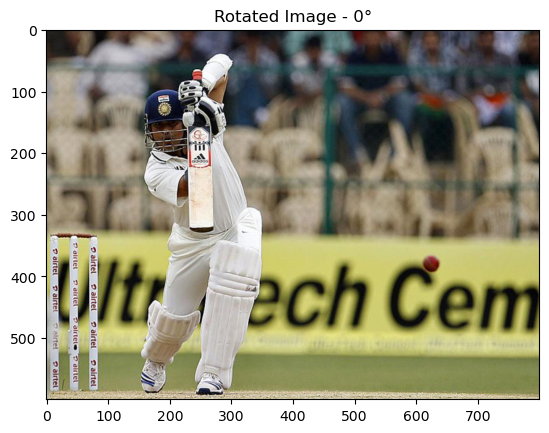

Completed rotation 0° for cricket_1.jpg


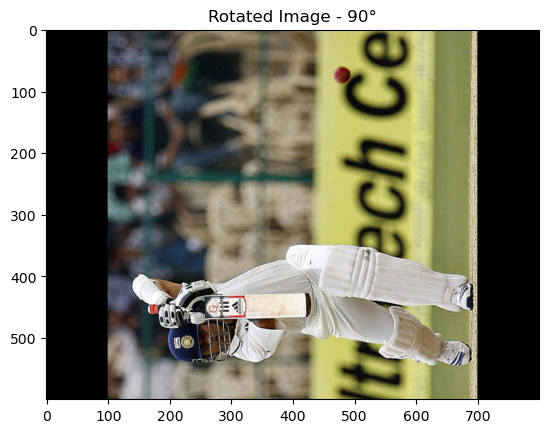

Completed rotation 90° for cricket_1.jpg


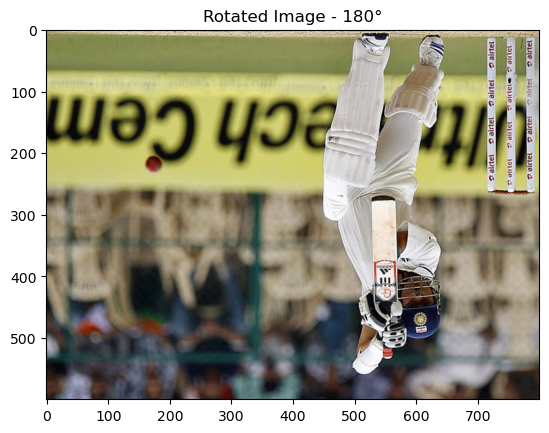

Completed rotation 180° for cricket_1.jpg


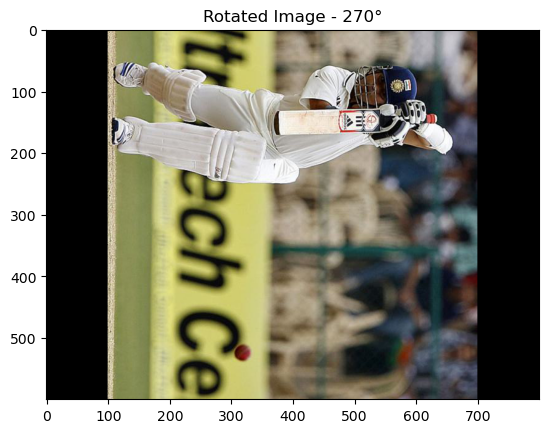

Completed rotation 270° for cricket_1.jpg


In [ ]:
rotation('cricket_1.jpg')  # Replace with an actual image filename from your dataset